# Hyperparameter search
We plot the performance over a number of thresholds for all training configurations.

In [3]:
from bl3d import evaluate, params
import datajoint as dj
import matplotlib.pyplot as plt
import numpy as np

dj.config['display.limit']=10

In [4]:
params.TrainingParams()

training_id unique id for hyperparameter combination,seed random seed for torch/np,normalize_volume whether to local contrast normalize the stacks,centroid_radius radius of the centroids to predict,soften_label whether to use soft labels (0.05/0.95) during training,train_crop_size size of the crops used during training,val_crop_size size of the random crops used for validation,learning_rate initial learning rate for SGD,momentum momentum factor for SGD updates,weight_decay lambda for l2-norm weight regularization,lr_decay factor multiplying learning rate when decreasing,num_epochs number of training epochs,val_epochs run validation every this number of epochs,decay_epochs number of epochs to wait before decreasing learning rate if val loss has not improved,nsn_loss_weight weight for the nsn loss (ndn loss has weight 1),ndn_pos_weight relative weight for positive class examples in the NDN (negative class weight is 1),nsn_pos_weight relative weight for positive class examples in the NSN (negative class weight is 1),ndn_threshold percentile used as threshold when computing IOU,nsn_threshold percentile used as threshold when computing IOU
1,1234,1,2,0,128,192,0.01,0.9,0.0,0.1,150,1,10,0.1,300.0,10.0,99.7,91.0
2,1234,1,2,0,128,192,0.01,0.9,0.0,0.1,150,1,10,1.0,300.0,10.0,99.7,91.0
3,1234,1,2,0,128,192,0.01,0.9,0.0,0.1,150,1,10,10.0,300.0,10.0,99.7,91.0
4,1234,1,2,0,128,192,0.01,0.9,0.0001,0.1,150,1,10,0.1,300.0,10.0,99.7,91.0
5,1234,1,2,0,128,192,0.01,0.9,0.0001,0.1,150,1,10,1.0,300.0,10.0,99.7,91.0
6,1234,1,2,0,128,192,0.01,0.9,0.0001,0.1,150,1,10,10.0,300.0,10.0,99.7,91.0
7,1234,1,2,0,128,192,0.01,0.9,0.01,0.1,150,1,10,0.1,300.0,10.0,99.7,91.0
8,1234,1,2,0,128,192,0.01,0.9,0.01,0.1,150,1,10,1.0,300.0,10.0,99.7,91.0
9,1234,1,2,0,128,192,0.01,0.9,0.01,0.1,150,1,10,10.0,300.0,10.0,99.7,91.0
10,1234,1,2,0,128,192,0.1,0.9,0.0,0.1,150,1,10,0.1,300.0,10.0,99.7,91.0


## Semantic segmentation metrics
### BestNDN Results
IOU with best threshold for each training param. Detection IOU is 
underestimated because the threshold was lower than optimal.

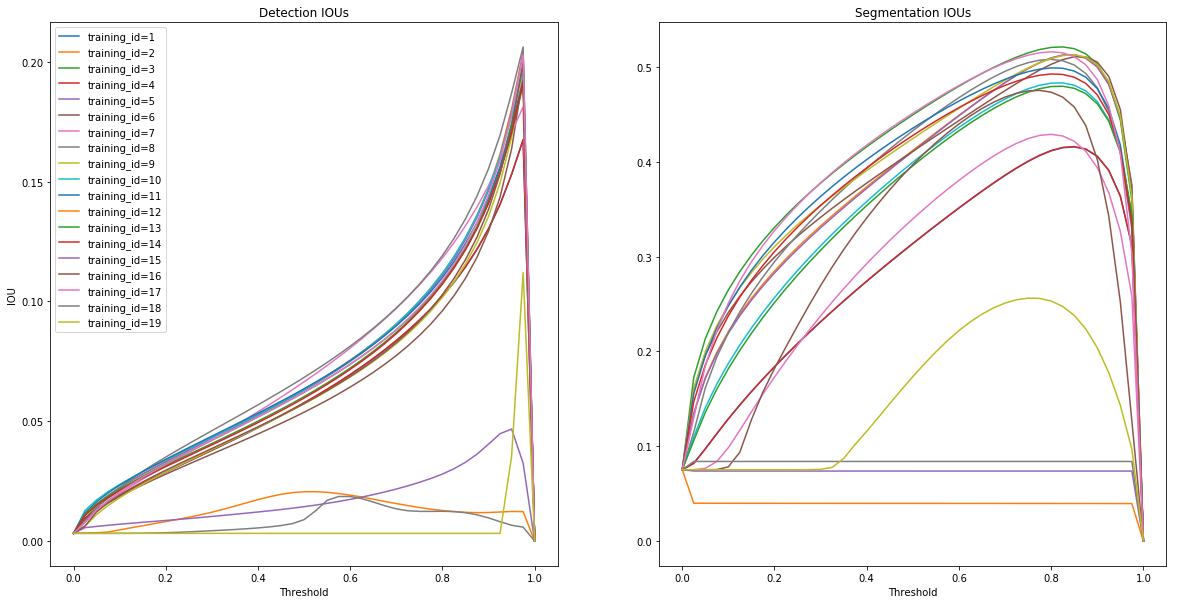

In [157]:
avg_ious = dj.U('model_version', 'training_id', 'threshold').aggr(evaluate.SemanticMetrics.BestNDN, 
                                                                  detection_iou='AVG(detection_iou)', 
                                                                  segmentation_iou='AVG(segmentation_iou)')
num_thresholds = 41
thresholds = np.linspace(0, 1, num_thresholds)
detection_ious, segmentation_ious = avg_ious.fetch('detection_iou', 'segmentation_iou', order_by='training_id, threshold')
detection_ious = detection_ious.reshape(-1, num_thresholds) # train_ids x thresholds
segmentation_ious = segmentation_ious.reshape(-1, num_thresholds) # train_ids x thresholds

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(20, 10))
axes[0].set_title('Detection IOUs')
axes[1].set_title('Segmentation IOUs')
axes[0].set_xlabel('Threshold')
axes[1].set_xlabel('Threshold')
axes[0].set_ylabel('IOU')
for i, (detection_ious_, segmentation_ious_) in enumerate(zip(detection_ious, segmentation_ious), start=1):
    axes[0].plot(thresholds, detection_ious_, 
                 label='training_id={}'.format(i))
    axes[1].plot(thresholds, segmentation_ious_, 
                 label='training_id={}'.format(i))
axes[0].legend()

In [19]:
np.max(detection_ious, axis=1) * 100 # IOU for best threshold (per param)

array([16.74853526055813, 20.413554459810257, 19.9638731777668,
       16.742603480815887, 20.340370386838913, 19.40538138151169,
       18.120238557457924, 20.617012679576874, 19.568821042776108,
       19.680770114064217, 19.248874858021736, 2.0590234198607504,
       19.017058238387108, 19.145502150058746, 4.673773888498545,
       19.922930002212524, 20.292745530605316, 1.8605433055199683,
       11.201736144721508], dtype=object)

In [161]:
thresholds[34]

0.8500000000000001

#### learning rate 0.01 (detection IOU / segmentation IOU)
| lambda / weight |     0.1     |      1        |      10       |
|-----------------|:-----------:|:-------------:|:-------------:|
| 0               | 16.75/41.58 | 20.41/51.28   | 19.96/**52.13**   | 
| 0.0001          | 16.74/41.61 | 20.34/51.32   | 19.41/51.09   |
| 0.01            | 18.12/42.91 | **20.62**/50.81   | 19.57/51.30   |

#### learning rate 0.1 (detection IOU / segmentation IOU)
| lambda / weight |     0.1     |      1        |      10       |
|-----------------|:-----------:|:-------------:|:-------------:|
| 0               | 19.68/48.33 | 19.25/49.92   |   2.06/7.53   | 
| 0.0001          | 19.02/47.98 | 19.15/49.27   |   4.67/7.53   |
| 0.01            | 19.92/47.54 | 20.29/51.61   |   1.86/8.40    |

#### learning rate 1
Everything diverges

### BestNSN Results
IOU with best threshold for each training param. Detection IOU is 
underestimated because the threshold was lower than optimal.

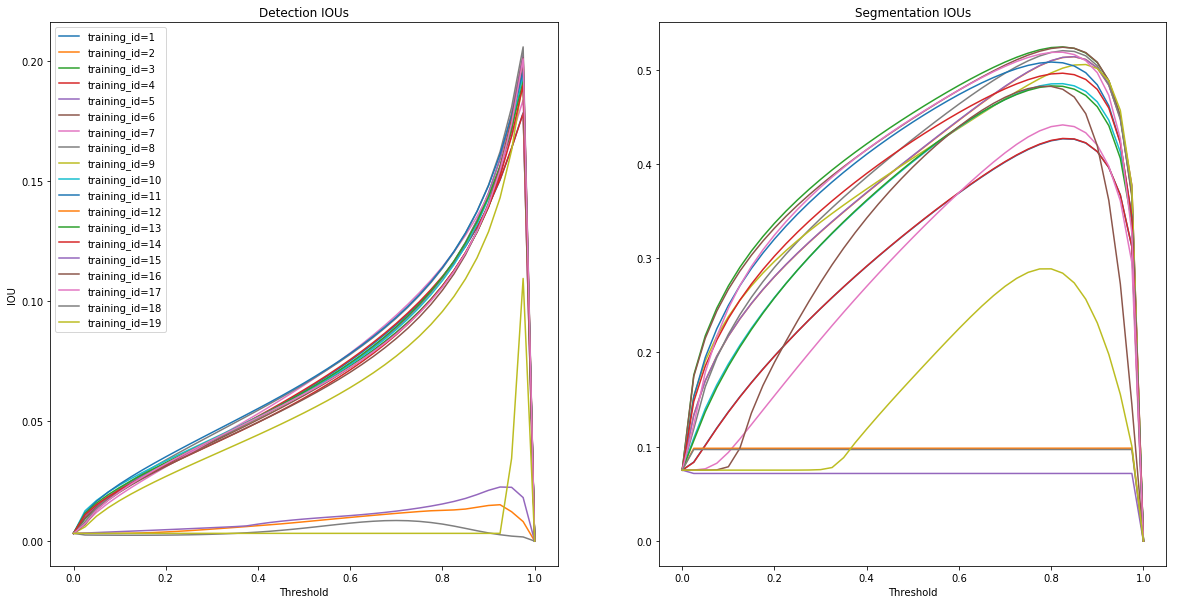

In [20]:
# Results using the bestndn network
avg_ious = dj.U('model_version', 'training_id', 'threshold').aggr(evaluate.SemanticMetrics.BestNSN, 
                                                                  detection_iou='AVG(detection_iou)', 
                                                                  segmentation_iou='AVG(segmentation_iou)')
num_thresholds = 41
thresholds = np.linspace(0, 1, num_thresholds)
detection_ious, segmentation_ious = avg_ious.fetch('detection_iou', 'segmentation_iou', order_by='training_id, threshold')
detection_ious = detection_ious.reshape(-1, num_thresholds) # train_ids x thresholds
segmentation_ious = segmentation_ious.reshape(-1, num_thresholds) # train_ids x thresholds

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(20, 10))
axes[0].set_title('Detection IOUs')
axes[1].set_title('Segmentation IOUs')
axes[0].set_xlabel('Threshold')
axes[1].set_xlabel('Threshold')
axes[0].set_ylabel('IOU')
for i, (detection_ious_, segmentation_ious_) in enumerate(zip(detection_ious, segmentation_ious), start=1):
    axes[0].plot(thresholds, detection_ious_, 
                 label='training_id={}'.format(i))
    axes[1].plot(thresholds, segmentation_ious_, 
                 label='training_id={}'.format(i))
axes[0].legend()

In [191]:
np.max(segmentation_ious, axis=1) * 100 # IOU for best threshold (per param)

array([42.658449336886406, 51.36263966560364, 52.40340307354927,
       42.69515499472618, 51.37052908539772, 52.369214594364166,
       44.13260519504547, 52.00387015938759, 50.535161793231964,
       48.50650355219841, 50.79834759235382, 9.852614533156157,
       48.26716333627701, 49.61553066968918, 7.525096274912357,
       48.216746002435684, 51.84123516082764, 9.710967913269997],
      dtype=object)

#### learning rate 0.01 (detection IOU / segmentation IOU)
| lambda / weight |     0.1     |      1        |      10       |
|-----------------|:-----------:|:-------------:|:-------------:|
| 0               | 17.85/42.66 | 20.25/51.36   | 19.70/**52.40**   | 
| 0.0001          | 17.83/42.70 | 20.27/51.37   | 19.79/52.37   |
| 0.01            | 18.38/44.13 | **20.60**/52.00   | 19.22/50.53   |

#### learning rate 0.1 (detection IOU / segmentation IOU)
| lambda / weight |     0.1     |      1        |      10       |
|-----------------|:-----------:|:-------------:|:-------------:|
| 0               | 19.43/48.51 | 19.59/50.80   |   1.52/9.85   | 
| 0.0001          | 19.14/48.27 | 19.01/49.62   |   2.25/7.53   |
| 0.01            | 20.14/48.22 | 20.10/51.84   |   0.86/9.71   |

#### learning rate 1
Everything diverges

### Conclusions
Results in bestNDN and bestNSN track each other nicely. As expected, bestNDN 
has slightly higher detection IOUs and bestNSN has slightly higher segmentation IOUs.

best_ndn training id 3 may be the best compromise (20/52).

## Instance segmentation metrics
### BestNDN results
MuCov: Mean over the maximum IOU for each predicted mask with a ground truth object.

AP@50: Average precision using 50% as IOU acceptance ratio (only predicted mask with IOU > 50% with some ground truth mask are true)

MAP: Mean average precision over IOUs in [0.5, 0.55, ...., 0.9]. COCO metric

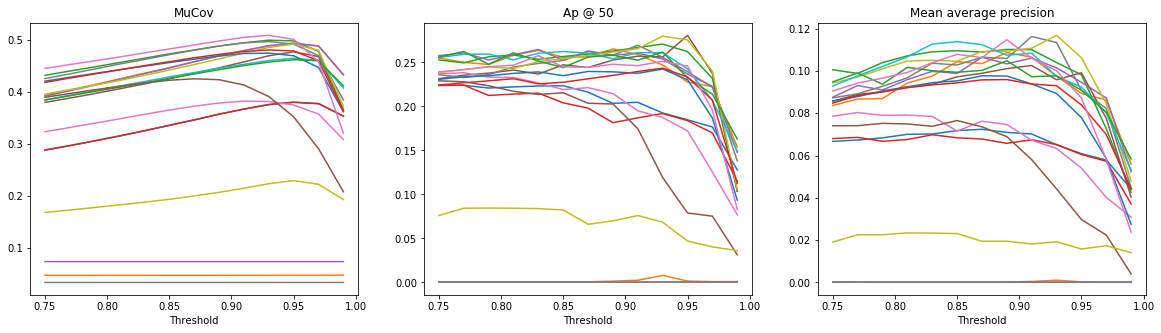

In [22]:
avg_mucovs = dj.U('model_version', 'training_id', 'threshold').aggr(evaluate.InstanceMetrics.BestNDNMuCov, mucov='AVG(mucov)')
avg_ap50s = dj.U('model_version', 'training_id', 'threshold').aggr(evaluate.InstanceMetrics.BestNDNAP & 'iou=0.5', ap50='AVG(ap)')
avg_maps = dj.U('model_version', 'training_id', 'threshold').aggr(evaluate.InstanceMetrics.BestNDNAP, map_='AVG(ap)')

num_thresholds = 13
thresholds = np.linspace(0.75, 0.99, num_thresholds)
mucovs = avg_mucovs.fetch('mucov', order_by='training_id, threshold').reshape(-1, num_thresholds)
ap50s = avg_ap50s.fetch('ap50', order_by='training_id, threshold').reshape(-1, num_thresholds)
maps = avg_maps.fetch('map_', order_by='training_id, threshold').reshape(-1, num_thresholds)

fig, axes = plt.subplots(1, 3, sharex=True, figsize=(20, 5))
axes[0].set_title('MuCov')
axes[1].set_title('Ap @ 50')
axes[2].set_title('Mean average precision')
axes[0].set_xlabel('Threshold')
axes[1].set_xlabel('Threshold')
axes[2].set_xlabel('Threshold')
for i, (mucov, ap50, map_) in enumerate(zip(mucovs, ap50s, maps), start=1):
    axes[0].plot(thresholds, mucov,  label='training_id={}'.format(i))
    axes[1].plot(thresholds, ap50, label='training_id={}'.format(i))
    axes[2].plot(thresholds, map_, label='training_id={}'.format(i))
#axes[0].legend()

In [26]:
np.max(maps, axis=1) * 100 # IOU for best threshold (per param)

array([7.240688165447865, 10.865479998465162, 11.014490707857476,
       6.980953175734612, 10.645184812083244, 10.257404904723444,
       8.030850587310852, 11.626791857943317, 11.680095841511502,
       11.382498182647396, 9.767270808952162, 0.10739130263232254,
       10.478411958974903, 9.589443367221975, 0.0, 7.652824090328067,
       11.474643698929867, 0.00903609471947675, 2.3431261431869643],
      dtype=object)

#### learning rate 0.01 (MuCOv / AP@50 / MAP)
| lambda / weight |        0.1       |        1          |       10          |
|-----------------|:----------------:|:-----------------:|:-----------------:|
| 0               | 38.00/22.40/7.24 | 49.34/26.53/10.87 | 49.96/27.08/11.01 | 
| 0.0001          | 38.03/22.41/6.98 | 49.39/26.46/10.65 | 47.72/**28.07**/10.26 |
| 0.01            | 38.24/23.83/8.03 | 49.70/26.95/11.63 | 49.21/27.98/**11.68** |

#### learning rate 0.1
| lambda / weight |        0.1        |         1         |        10         |
|-----------------|:-----------------:|:-----------------:|:-----------------:|
| 0               | 46.49/26.23/11.38 | 47.47/24.24/9.77  | errored (single point prediction) | 
| 0.0001          | 46.20/26.24/10.48 | 48.08/24.34/9.59  | errored (single point prediction)  |
| 0.01            | 42.54/22.91/7.65  | **50.89**/25.76/11.47 | errored (single point prediction)   |

#### learning rate 1
Everything diverges

### BestNSN results
MuCov: Mean over the maximum IOU for each predicted mask with a ground truth object.

AP@50: Average precision using 50% as IOU acceptance ratio (only predicted mask with IOU > 50% with some ground truth mask are true)

MAP: Mean average precision over IOUs in [0.5, 0.55, ...., 0.9]. COCO metric

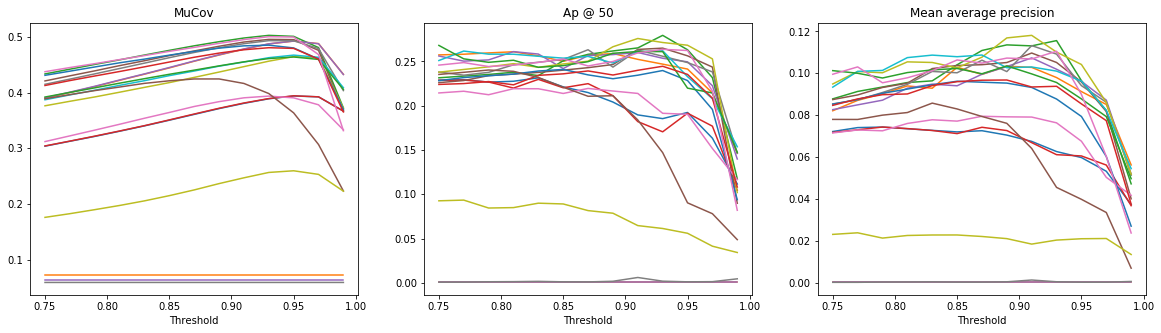

In [28]:
avg_mucovs = dj.U('model_version', 'training_id', 'threshold').aggr(evaluate.InstanceMetrics.BestNSNMuCov, mucov='AVG(mucov)')
avg_ap50s = dj.U('model_version', 'training_id', 'threshold').aggr(evaluate.InstanceMetrics.BestNSNAP & 'iou=0.5', ap50='AVG(ap)')
avg_maps = dj.U('model_version', 'training_id', 'threshold').aggr(evaluate.InstanceMetrics.BestNSNAP, map_='AVG(ap)')

num_thresholds = 13
thresholds = np.linspace(0.75, 0.99, num_thresholds)
mucovs = avg_mucovs.fetch('mucov', order_by='training_id, threshold').reshape(-1, num_thresholds)
ap50s = avg_ap50s.fetch('ap50', order_by='training_id, threshold').reshape(-1, num_thresholds)
maps = avg_maps.fetch('map_', order_by='training_id, threshold').reshape(-1, num_thresholds)

fig, axes = plt.subplots(1, 3, sharex=True, figsize=(20, 5))
axes[0].set_title('MuCov')
axes[1].set_title('Ap @ 50')
axes[2].set_title('Mean average precision')
axes[0].set_xlabel('Threshold')
axes[1].set_xlabel('Threshold')
axes[2].set_xlabel('Threshold')
for i, (mucov, ap50, map_) in enumerate(zip(mucovs, ap50s, maps), start=1):
    axes[0].plot(thresholds, mucov,  label='training_id={}'.format(i))
    axes[1].plot(thresholds, ap50, label='training_id={}'.format(i))
    axes[2].plot(thresholds, map_, label='training_id={}'.format(i))
#axes[0].legend()

In [31]:
np.max(maps, axis=1) * 100 # IOU for best threshold (per param)

array([7.427343696144817, 10.335679171257652, 11.557373779633053,
       7.429365559073631, 10.730987231381732, 10.9637649346314,
       7.94369228985488, 11.31907765282449, 11.807929184760724,
       10.868929708140058, 9.615604127247934, 0.011119556039602685,
       10.348244072010857, 9.675022776646074, 0.005964406736893579,
       8.571289813557996, 11.046766995841608, 0.12201840256011565,
       2.3771778106311103], dtype=object)

#### learning rate 0.01 (MuCov / AP@50 / MAP)
| lambda / weight |        0.1       |        1          |       10          |
|-----------------|:----------------:|:-----------------:|:-----------------:|
| 0               | 39.40/23.15/7.43 | 49.27/26.09/10.34 | **50.29**/**27.94**/11.56 | 
| 0.0001          | 39.43/22.97/7.43 | 49.26/26.10/10.73 | 49.56/26.50/10.96 |
| 0.01            | 39.37/21.95/7.94 | 49.34/26.32/11.32 | 46.47/27.59/**11.81** |

#### learning rate 0.1
| lambda / weight |        0.1        |         1         |        10         |
|-----------------|:-----------------:|:-----------------:|:-----------------:|
| 0               | 46.74/26.20/10.87 | 48.52/24.10/9.62  | errored (single point prediction) | 
| 0.0001          | 46.40/26.81/10.35 | 48.07/24.45/9.68  | errored (single point prediction) |
| 0.01            | 42.45/24.03/8.57  | 50.05/26.36/11.05 | errored(single point predictions) |

#### learning rate 1
Everything diverges

### Conclusion
training id 3, bestnsn seems to be the better option overall: 19.7 detection iou, 52.1 segmentation iou, 50.3 MuCOV, 27.9 ap@50 and 11.6 mAP

## Results per animal id
best_training_id (value of the metric)
detection iou may be unreliable

### bestndn
|Animal | detection IOU | segmentation IOU | MuCOV | AP50 | MAP | Notes |
|-------|:-------------:|:----------------:|:-----:|:----:|:---:|:-----:|
| 17026 | 10 (25.5) | 9(61.3) | 9(54.9)  | 9(41.3) |  9(19.9)|
| 17206 | 17(18.0)  | 17(48.5)| 17(46.3) | 13(21.4)| 6(7.5)  | ap and map are noisy |
| 17259 | 3(15.4)   | 8(39.1) | 3(47.8)  | 9(20.8) | 3(8.2)  | ap and map are noisy |
| 17261 | 9(26.5)   | 9(63.9) | 17(59.5) | 9(34.3) | 8(15.3) |

### bestnsn
|Animal | detection IOU | segmentation IOU | MuCOV | AP50 | MAP | Notes |
|-------|:-------------:|:----------------:|:-----:|:----:|:---:|:-----:|
| 17026 | 16(25.2) | 3(61.3)  | 9(54.9)  | 9(41.4)  | 9(19.9) |
| 17206 | 8(16.7)  | 17(48.8) | 17(45.5) | 13(21.1) | 3(8.1)  | ap and map are noisy
| 17259 | 8(14.9)  | 8(39.5)  | 3(47.5)  | 9(21.5)  | 17(8.9) | ap and map are noisy
| 17261 | 9(26.4)  | 9(63.5)  | 8(59.1) | 8(34.3) | 8(15.3) |

## Conclusion
Use diff training ids per animal.

NDN: 9 for 17026, 17 for 17206, 3 for 17259, 8 for 17261

NSN: 9 for 17026, 17 for 17206, 8 for 17259, 8 for 17261

Use NDN. 

## Save selected models
We save one per animal in case we want to ensemble them later

In [156]:
from bl3d import train
import torch
for training_id, val_animal in zip([9, 17, 3, 8], [17026, 17206, 17259, 17261]):
    net = train.QCANet.load_model({'training_id': training_id, 'val_animal': val_animal}, 'bestndn')
    torch.save(net.state_dict(), '../data/bestndn_1-{}-{}.pth'.format(training_id, val_animal))

## Select thresholds

0.8500000000000001 0.91


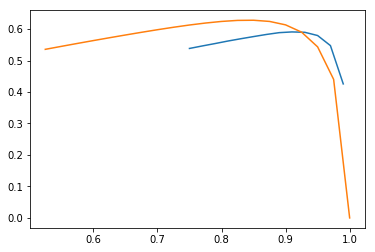

In [188]:
key = {'training_id': 8, 'val_animal': 17261}
mucovs = (evaluate.InstanceMetrics.BestNDNMuCov & key).fetch('mucov', order_by='threshold')
segmentation_ious = (evaluate.SemanticMetrics.BestNSN & key).fetch('segmentation_iou', order_by='threshold')

mucov_thresholds = np.linspace(0.75, 0.99, 13)
iou_thresholds = np.linspace(0, 1, 41)
plt.plot(mucov_thresholds, mucovs)
plt.plot(iou_thresholds[-20:], segmentation_ious[-20:])

print(iou_thresholds[np.argmax(segmentation_ious)], mucov_thresholds[np.argmax(mucovs)])

| Animal | Threshold (IOU) | Threshold (mucov) |
|--------|:---------------:|:-----------------:|
| 17026 | 0.85  | 0.93 |
| 17206 | 0.825 | 0.93 |
| 17259 | 0.775 | 0.95 |
| 17261 | 0.85  | 0.91 |

In [189]:
(0.85 + 0.825 + 0.775 + 0.85)/ 4 # average threshold

0.825